<h1>MNIST DATASET </h1>

# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import cv2
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import warnings                      
warnings.simplefilter("ignore")  # ignores the warning

from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load .npy file

In [2]:
# Load the MNIST data from .npy file
data = np.load('data/mnist_data.npy', allow_pickle=True)
images = data.item().get('images')
labels = data.item().get('labels')

# Visualize

In [3]:
import random

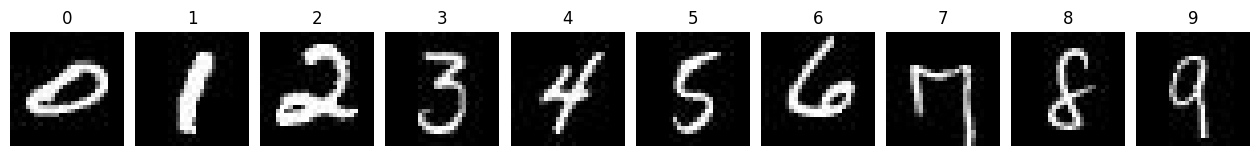

In [4]:
def random_value_for_index(labels, target_value):
    indices = [index for index, value in enumerate(labels) if value == target_value]
    return random.choice(indices)

# Define categories
categories = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create subplots
fig, axs = plt.subplots(1, 10, figsize=(16, 16))

for index, category in enumerate(categories):
    # Select random image index from specific category
    random_index = random_value_for_index(labels, category)
    # Plot the random image
    axs[index].imshow(images[random_index].reshape(28, 28), cmap='gray')
    axs[index].axis('off')
    axs[index].set_title(category)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# Train Test Split

In [5]:
x_train,x_test,y_train,y_test = train_test_split(images, labels, test_size=0.2, random_state=11)

In [6]:
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

In [7]:
x_train_reshaped = x_train.reshape((-1,28, 28,1))
x_test_reshaped = x_test.reshape((-1,28,28,1))

In [8]:
print("X_train shape : ",x_train_reshaped.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape : ",x_test_reshaped.shape)
print("y_test shape : ",y_test.shape)


X_train shape :  (33600, 28, 28, 1)
y_train shape :  (33600,)
X_test shape :  (8400, 28, 28, 1)
y_test shape :  (8400,)


# Rotate X_test

In [9]:
datagen = ImageDataGenerator(rotation_range=95)
x_test_rotated = datagen.flow(x_test_reshaped, batch_size=len(x_test_reshaped), shuffle=False).next()

x_test_combined = np.concatenate((x_test_reshaped, x_test_rotated), axis=0)

y_test_combined = np.concatenate((y_test, y_test), axis=0)

x_test_combined, y_test_combined = shuffle(x_test_combined, y_test_combined, random_state=42)

# Also rotate x_train

In [10]:
datagen = ImageDataGenerator(rotation_range=90)
x_train_rotated = datagen.flow(x_train_reshaped, batch_size=len(x_train_reshaped), shuffle=False).next()

x_train_combined = np.concatenate((x_train_reshaped, x_train_rotated), axis=0)

y_train_combined = np.concatenate((y_train, y_train), axis=0)

x_train_combined, y_train_combined = shuffle(x_train_combined, y_train_combined, random_state=42)

# Train CNN model

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [12]:
model=Sequential()

model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1), name='conv1'))
model.add(MaxPooling2D(pool_size=(2,2), name = 'maxpool1'))
model.add(BatchNormalization(name = 'batch1'))

# model.add(Dropout(0.25, name='dropout1'))

model.add(Conv2D(filters=16, kernel_size = (3,3), activation="relu", name='conv2'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2'))
model.add(BatchNormalization(name='batch2'))

# model.add(Dropout(0.25, name='dropout2'))
    
model.add(Flatten(name='flatten'))
model.add(Dense(64, activation='relu', name='dense1'))

# model.add(Dropout(0.2, name='dropout3')) 

model.add(Dense(32, activation='relu', name='dense2'))

# model.add(Dropout(0.2, name='dropout4'))

model.add(Dense(10,activation="softmax"))
    

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 26, 26, 64)        640       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 13, 13, 64)        0         
                                                                 
 batch1 (BatchNormalization  (None, 13, 13, 64)        256       
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 11, 11, 16)        9232      
                                                                 
 maxpool2 (MaxPooling2D)     (None, 5, 5, 16)          0         
                                                                 
 batch2 (BatchNormalization  (None, 5, 5, 16)          64        
 )                                                      

# Early Stopping

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_accuracy',patience=5)

In [15]:
# log_dir = "logs/overfitting_underfitting/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/overfitting_underfitting/run1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Compile

In [16]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train

In [17]:
history = model.fit(x_train_reshaped, y_train, epochs=5, validation_data=(x_test_combined, y_test_combined), batch_size=32,callbacks=[early_stop,tensorboard_callback])

Epoch 1/5
1050/1050 [==============================] - 135s 120ms/step - loss: 0.3531 - accuracy: 0.9018 - val_loss: 1.0970 - val_accuracy: 0.7063
Epoch 2/5
1050/1050 [==============================] - 127s 121ms/step - loss: 0.1077 - accuracy: 0.9681 - val_loss: 1.1594 - val_accuracy: 0.7356
Epoch 3/5
1050/1050 [==============================] - 137s 130ms/step - loss: 0.0799 - accuracy: 0.9763 - val_loss: 1.2956 - val_accuracy: 0.7071
Epoch 4/5
1050/1050 [==============================] - 140s 134ms/step - loss: 0.0645 - accuracy: 0.9805 - val_loss: 1.1669 - val_accuracy: 0.7411
Epoch 5/5
1050/1050 [==============================] - 127s 121ms/step - loss: 0.0546 - accuracy: 0.9840 - val_loss: 1.2784 - val_accuracy: 0.7331


# Metrics

In [18]:
metrics=pd.DataFrame(model.history.history)

<Axes: >

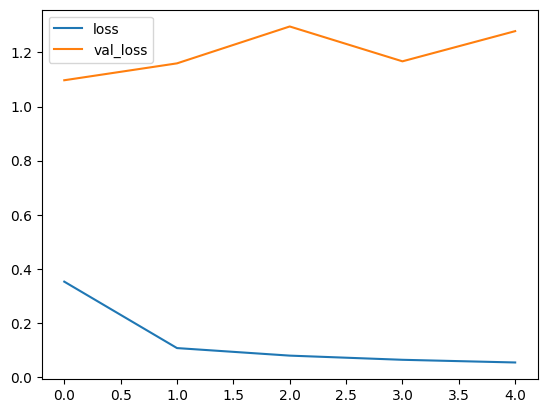

In [19]:
metrics[['loss','val_loss']].plot()

<Axes: >

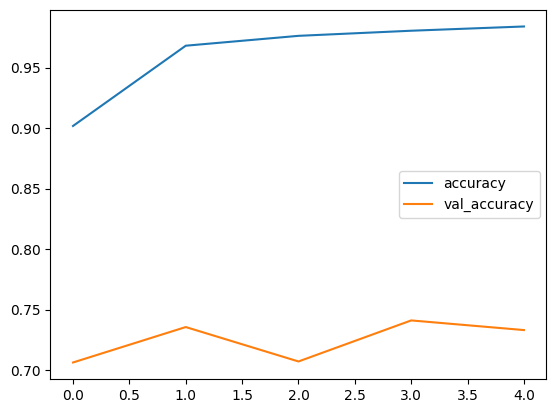

In [20]:
metrics[['accuracy', 'val_accuracy']].plot()

In [21]:
model.save("model/mnist_cnn.h5")

In [22]:
from keras.models import load_model
model= load_model("model/mnist_cnn.h5")

# Predict on Test data

In [23]:
y_pred = model.predict(x_test_reshaped)

263/263 [==============================] - 14s 34ms/step


In [24]:
y_pred = np.argmax(y_pred, axis=1)

<h2>Model Evaluation</h2>

In [25]:
from sklearn.metrics import accuracy_score,recall_score, precision_score, f1_score,classification_report

In [26]:
print("Model's acuracy :",accuracy_score(y_pred,y_test))
print("Recall-Score :",recall_score(y_pred,y_test,average="macro"))
print("Precision-Score :",precision_score(y_pred,y_test,average="macro"))
print("F1-Score :",f1_score(y_pred,y_test,average="macro"))

Model's acuracy : 0.965952380952381
Recall-Score : 0.9664639265155914
Precision-Score : 0.9657233023961844
F1-Score : 0.965700855185301


In [27]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       825
           1       0.97      0.99      0.98       909
           2       0.96      0.96      0.96       847
           3       0.99      0.92      0.95       940
           4       0.92      1.00      0.96       759
           5       0.98      0.95      0.96       799
           6       0.97      0.98      0.98       801
           7       0.98      0.97      0.97       919
           8       0.97      0.94      0.96       800
           9       0.95      0.95      0.95       801

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



# Confusion Matrix

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

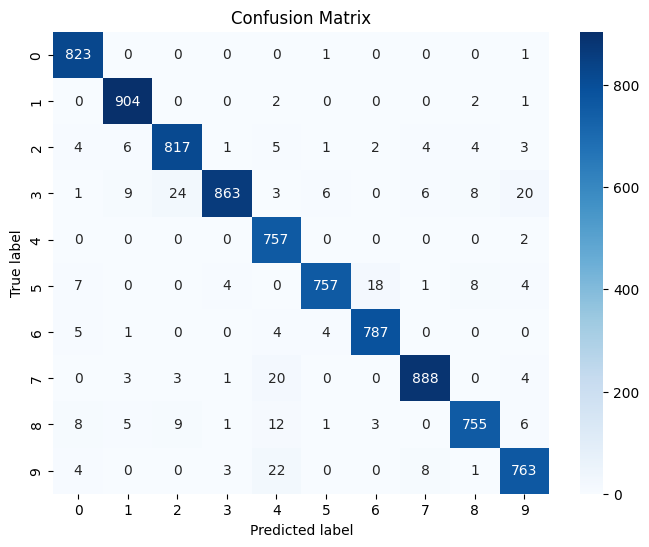

In [29]:
# Compute confusion matrix
cm = confusion_matrix(y_pred , y_test)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Visualize

In [30]:
from tensorflow.keras.models import Model

In [31]:
def get_layer_output(model, layer_name, input_image):
    layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    output = layer_model.predict(input_image)
    return output

def plot_conv_layer_outputs(layer_output, layer_name, num_columns=8):
    num_filters = layer_output.shape[-1]
    size = layer_output.shape[1]
    
    num_rows = int(np.ceil(num_filters / num_columns))
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns*2, num_rows*2))
    axes = axes.flatten()
    
    for i in range(num_filters):
        ax = axes[i]
        ax.imshow(layer_output[0, :, :, i], cmap='gray')
        ax.axis('off')
        ax.set_title(f'{layer_name} {i+1}')
    
    # Hide unused subplots
    for j in range(num_filters, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_dense_layer_output(layer_output, layer_name):
    plt.figure(figsize=(10, 5))
    plt.bar(range(layer_output.shape[1]), layer_output[0], color='skyblue')
    plt.title(f'{layer_name} Output')
    plt.xlabel('Neuron')
    plt.ylabel('Activation')
    plt.grid(True)
    plt.show()


In [32]:
sample_image = cv2.imread("data/test/img_3.jpg",cv2.IMREAD_GRAYSCALE)
sample_image = np.expand_dims(sample_image, axis=0)  


1/1 [==============================] - 2s 2s/step


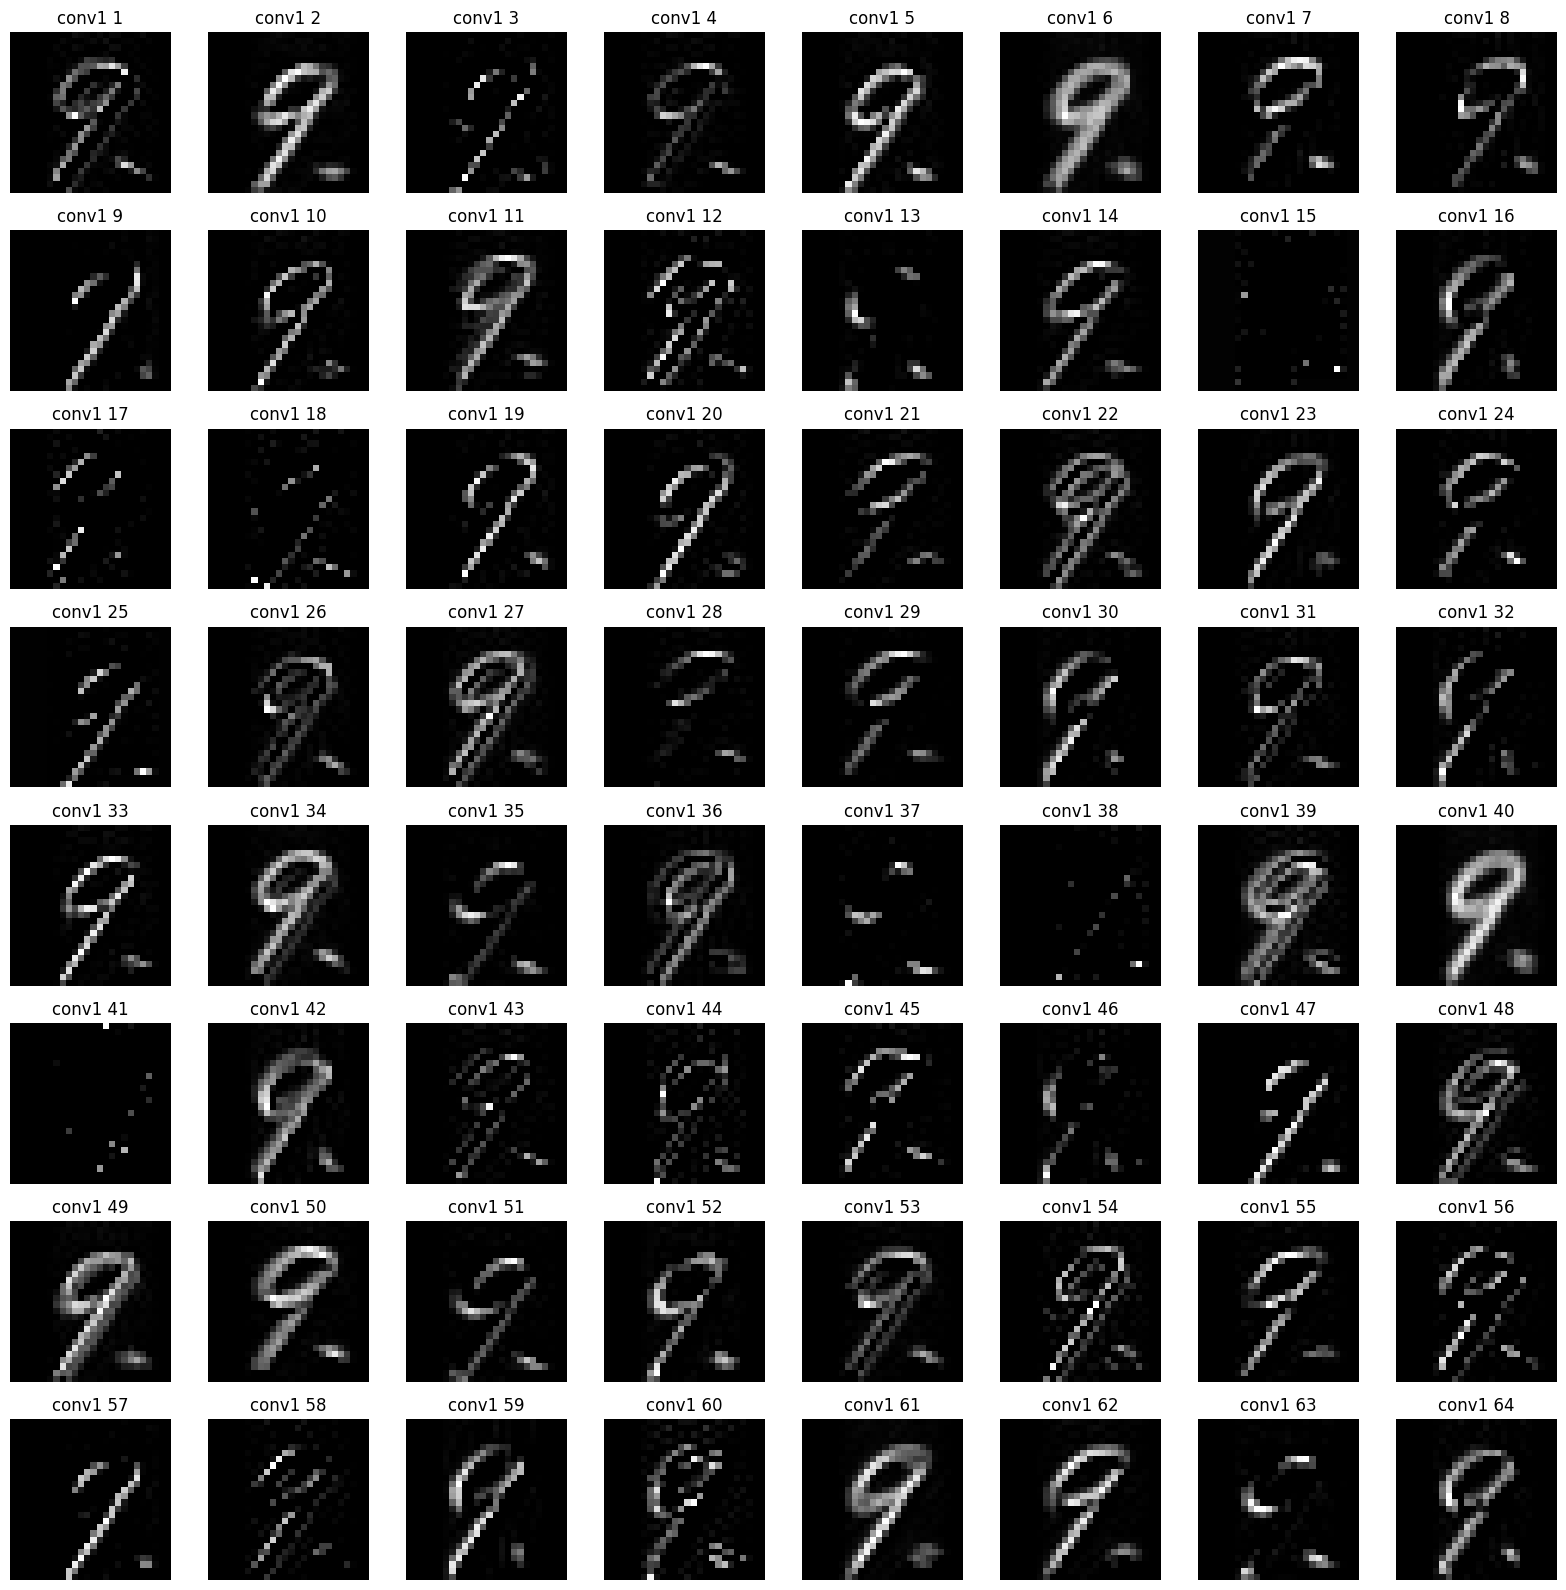

1/1 [==============================] - 0s 395ms/step


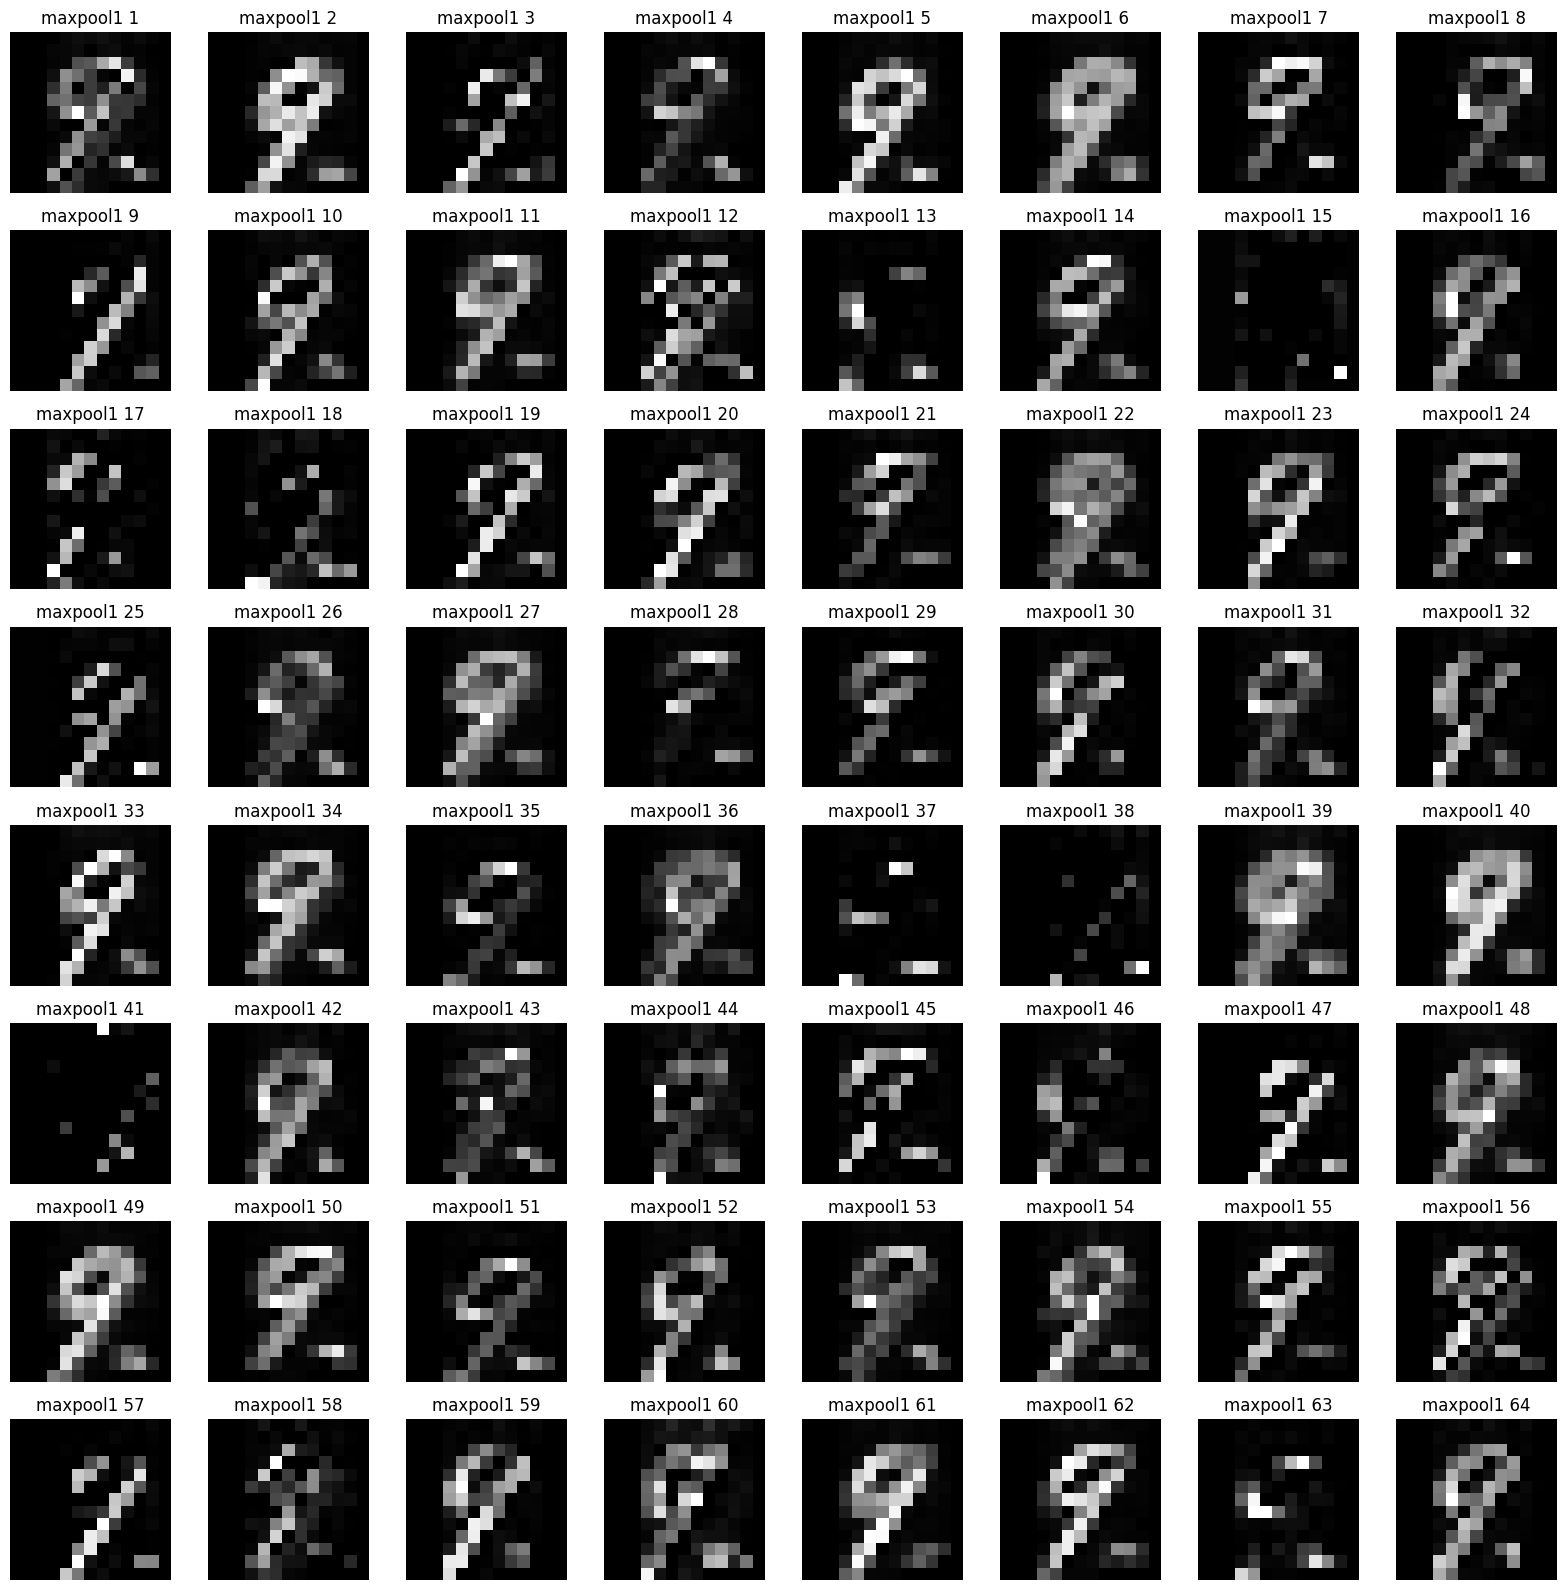

1/1 [==============================] - 1s 501ms/step


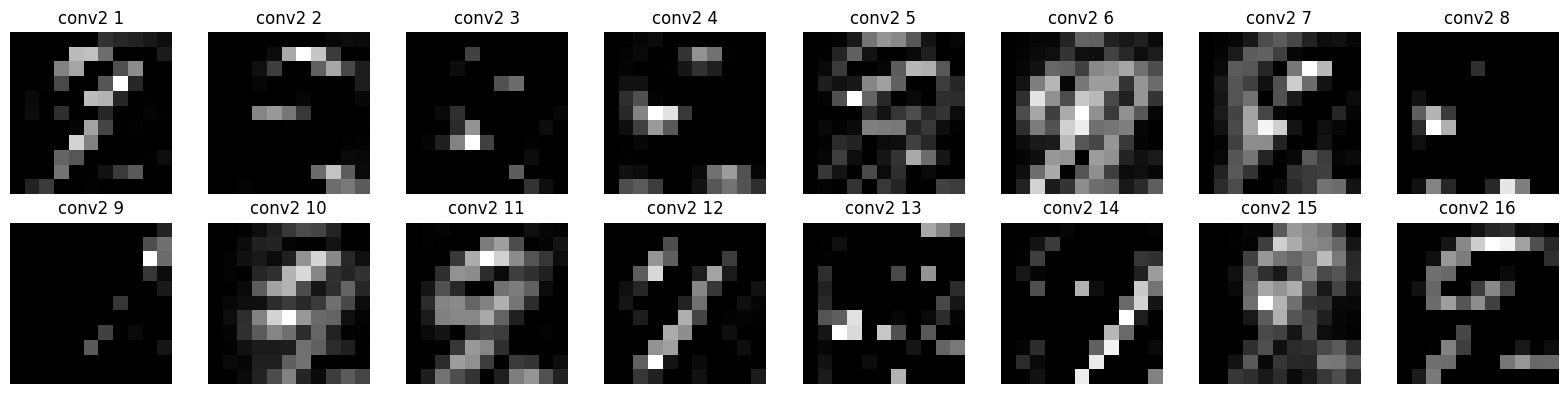

1/1 [==============================] - 0s 350ms/step


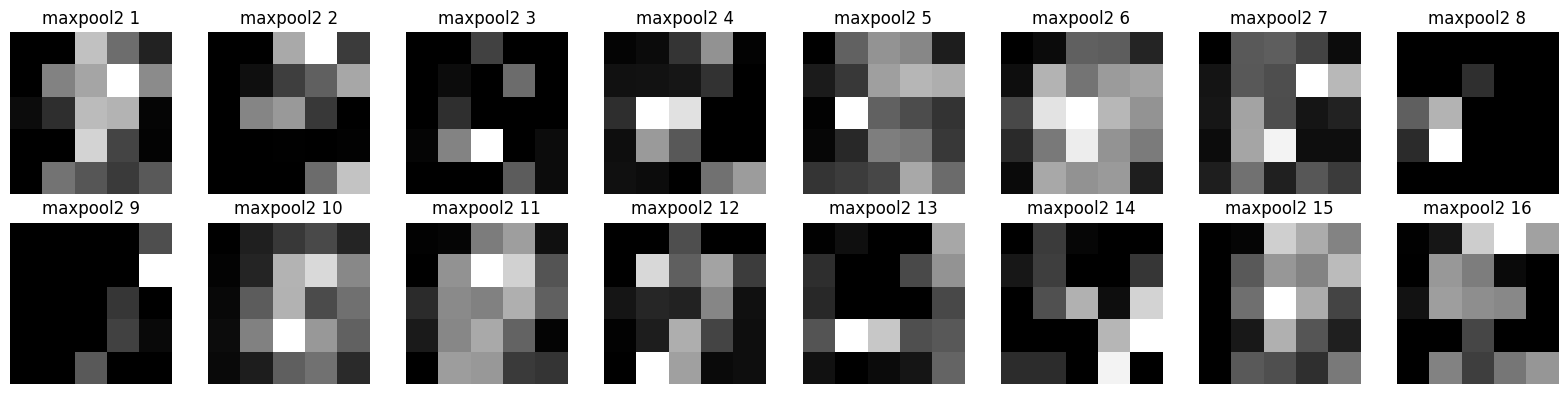

1/1 [==============================] - 0s 446ms/step


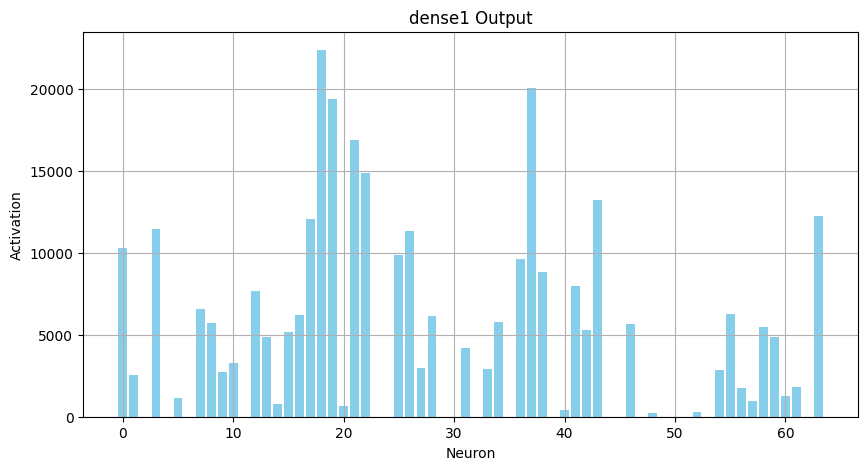

1/1 [==============================] - 1s 844ms/step


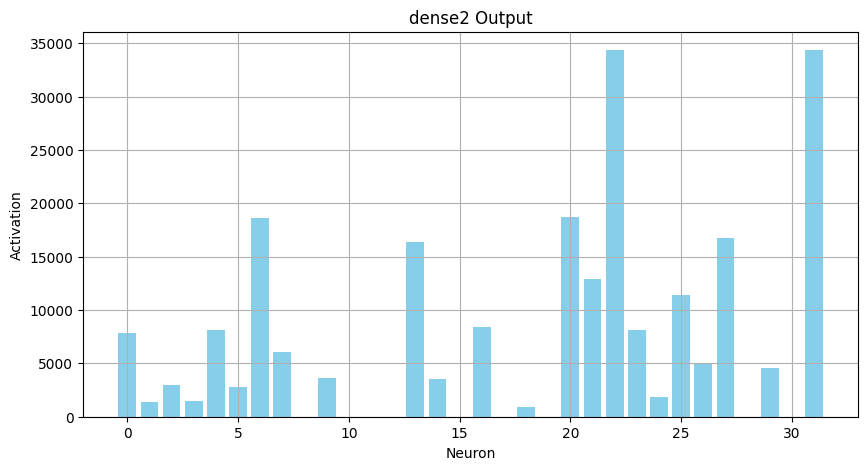

1/1 [==============================] - 1s 523ms/step


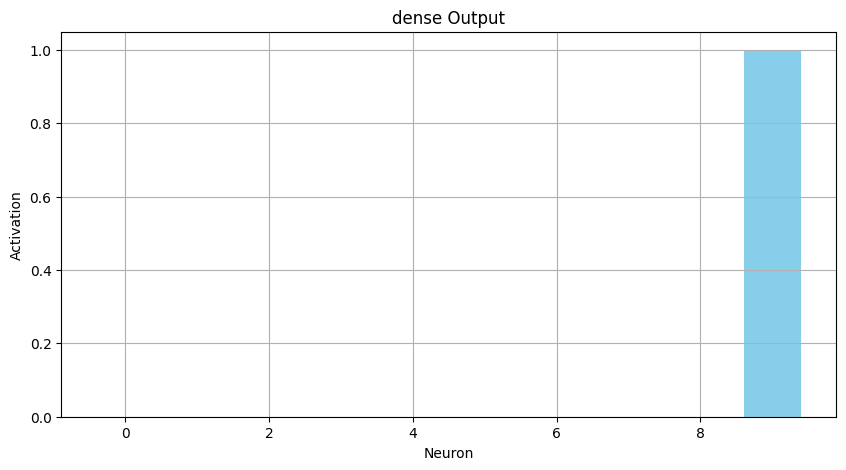

In [33]:
# Iterate through all layers to get and plot activations
for layer in model.layers:
    print(layer)
    
    # For convolutional layers
    if 'conv' in layer.name:
        layer_output = get_layer_output(model, layer.name, sample_image)
        plot_conv_layer_outputs(layer_output, layer.name)
    
    # For dense layers
    elif 'dense' in layer.name:
        layer_output = get_layer_output(model, layer.name, sample_image)
        plot_dense_layer_output(layer_output, layer.name)
    
    # For max pooling layers
    elif 'pool' in layer.name or 'max_pool' in layer.name:
        layer_output = get_layer_output(model, layer.name, sample_image)
        plot_conv_layer_outputs(layer_output, layer.name)  # Use the same function as for conv layers


# Assignment

<li> Perform Inference </li>